# Calculating the Distribution and Influnce Scores
### Our goals and objectives:
- First, we will calculate the memorization score for every idx in the training data. We will then calculate a distribution score for every idx in the pickle, and quantify the relationship between memorization score and the distribution score.
- There are many different ways to quantify the distribution score such as bubbling, concentric rings (determining density as a function of radius from the point), bubbling the areas and giving greater weight to some areas
- Objective: Determine a metric to predict memorization based on distribution
- Background: We know that sparseness gives memorization, and we see long tail distributions where samples at the end of the tail are memorized. We are looking for monotonic distribution
- Memorization is F1 score (with) - F1 (without), and depends on number of samples, but likely depends mostly on density of simmilar points near the sample, but also diversity of sample. 

Next steps: Influnce score
- Influence score: 
- 1000 x1000 matrix or IiI,j) influence of i on j. If i is in the training data (and j is not), 
- I (I,j) = Pj (I in TR)- Pj (I in TR). How the model reacts to j weather or not it has seen j before. This is influence score.
- continue the calculation per molecule type





## Loading in and sorting nessesary data by Mol. Type

In [102]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

tr_data = []  # Empty list to hold TR data
vl_data = []  # Empty list to hold VL data
memorization_score = []  # Empty list to hold memorization scores

data_path = '/Users/ilanastern/Documents/GitHub/aiConfidential/data' 

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(data_path):
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'): # Check if we are in a TR.eval or VL.eval folder
        for file in files:
            if file.startswith('eval_loss_meta'): # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                df = pd.read_csv(file_path)
                # Append to the appropriate list
                if root.endswith('_TR.eval'):
                    tr_data.append(df)
                elif root.endswith('_VL.eval'):
                    vl_data.append(df)

# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)

combined_df = pd.concat([tr_df, vl_df], ignore_index=True) # Concatenating the TR and VL dataframes

tr_df_sorted = tr_df.sort_values(by='moltype') # sorting the data by moltype
vl_df_sorted = vl_df.sort_values(by='moltype')


## Distribution Score Modeled as Exponential Decay

In [103]:
# Open the pickle file in read-binary mode and load the data
with open('/Users/ilanastern/Documents/GitHub/aiConfidential/nr80-vs-nr80.rnaforester.alnIdentity_pairwise.pkl', 'rb') as file:
    data = pickle.load(file)

data_df = pd.DataFrame(data)  # Renamed file to 'data_df'

# Rename idx values to stop before the first underscore so idx values match up to memorization score data
data_df.index = data_df.index.map(lambda x: str(x).split('_', 1)[0])
data_df.columns = data_df.columns.map(lambda x: str(x).split('_', 1)[0])

# Constants for the exponential decay function that I used to model the distribution scores, Values closest to 1 have the highest points (10)
#Values below 0.5 are worth 0 points. The function is A * exp(-B * (1 - score)) Values of 0.5 are worth 1 point

A = 10  # Maximum points for the highest score (close to 1)
B = np.log(A / 1) / (1 - 0)  # Solve for B based on the condition that 0.5 maps to 0 point

# Function to map similarity score to points based on the new rules
def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    elif score >= 1:  # Ignore scores that are 1 or greater
        return 0
    elif score < 0.5:  # Return 0 points for scores less than 0.5
        return 0
    else:  # Apply the exponential decay function for scores between 0.5 and 1
        return A * np.exp(-B * (1 - score))

similarity_scores = {} # Empty dictionary to hold similarity scores

for idx, row in data_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    points = row.apply(map_similarity_to_points).sum()
    # Store the total points as the overall similarity score for this 'idx'
    similarity_scores[idx] = points

similarity_scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame
print(similarity_scores_df)


        idx  similarity_score
0     34661       1977.292285
1     31262       2548.249572
2     37294         25.760373
3     34263       1682.328120
4     27176        230.464788
...     ...               ...
3408  26367        479.211166
3409  31446        732.201755
3410  28360        834.732351
3411  27863        622.818511
3412  17264       1175.048737

[3413 rows x 2 columns]


## Assigning 'idx' extracted from the pickle to a Mol. Type

In [104]:
combined_df['idx'] = combined_df['idx'].astype(str)  # Making sure both idx columns have the same type (int64 or object)
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)
df_merged = pd.merge(combined_df, similarity_scores_df, on='idx', how='left') #merging the simmilarity score to the dataframe containing the moltype
df_avg_similarity_by_idx = df_merged.groupby('idx').agg({'similarity_score': 'mean'}).reset_index() # Group by 'idx' and calculate the average of 'similarity_score'
df_avg_similarity_by_moltype = df_merged.groupby('moltype')['similarity_score'].mean().reset_index() # Finding average similarity score by moltype
df_avg_similarity_by_moltype = df_avg_similarity_by_moltype.rename(columns={'similarity_score': 'avg_similarity_score'}) # Renaming the column
print(df_avg_similarity_by_moltype)

      moltype  avg_similarity_score
0    16S-rRNA            188.653674
1    23S-rRNA             21.891712
2     5S-rRNA           1206.402266
3      RNaseP            191.251985
4         SRP             55.819339
5        TERC             38.200749
6  gpI-intron            143.918434
7        tRNA           1965.146703
8       tmRNA            111.271942


## Calculating Memorization Score For each Moltype (copied from PerformanceEval.ipynb)

In [105]:
tr_df_sorted = tr_df.sort_values(by='moltype') # sorting the data by moltype
vl_df_sorted = vl_df.sort_values(by='moltype')

# Create separate dataframes for each 'moltype' in TR and VL
tr_moltype_groups = {moltype: group for moltype, group in tr_df_sorted.groupby('moltype')}
vl_moltype_groups = {moltype: group for moltype, group in vl_df_sorted.groupby('moltype')}

tr_f1_scores = [] # Empty lists to hold the moltype name and F1 scores for TR and VL data
vl_f1_scores = []
table_data = [] #empty list to hold the data for the table

# Calculate average F1 score for each molecule type in TR and VL data
for moltype, df in tr_moltype_groups.items():
    avg_f1 = df['f1'].mean()  # calculates the average F1 score for each molecule type
    tr_f1_scores.append((moltype, avg_f1))  # appends the moltype name and average F1 score as a tuple

for moltype, df in vl_moltype_groups.items():
    avg_f1 = df['f1'].mean()
    vl_f1_scores.append((moltype, avg_f1))  # appends the moltype name and average F1 score as a tuple

vl_f1_dict = dict(vl_f1_scores) # Create a dictionary for VL F1 scores for easier lookup

# Generate the data for the table
for moltype, tr_f1 in tr_f1_scores:
    if moltype in vl_f1_dict:
        vl_f1 = vl_f1_dict[moltype]
        diff = tr_f1 - vl_f1
        num_datapoints_tr = len(tr_moltype_groups[moltype])  # Number of datapoints in TR
        num_datapoints_vl = len(vl_moltype_groups[moltype])  # Number of datapoints in VL
        table_data.append({
            'moltype': moltype,
            'TR F1 Score': tr_f1,
            'VL F1 Score': vl_f1,
            'Memorization Score': diff,
            'TR pop.': num_datapoints_tr,
            'VR pop.': num_datapoints_vl })
            
memorization_score_df1 = pd.DataFrame(table_data) #DF for all data
print(memorization_score_df1)

      moltype  TR F1 Score  VL F1 Score  Memorization Score  TR pop.  VR pop.
0    16S-rRNA     0.645861     0.514832            0.131029     3600     3225
1    23S-rRNA     0.695364     0.485277            0.210088      525      450
2     5S-rRNA     0.995298     0.938023            0.057275    17925    18300
3      RNaseP     0.813765     0.690094            0.123671     7500     7200
4         SRP     0.841506     0.584715            0.256791     6825     6525
5        TERC     0.500378     0.396180            0.104198      675      450
6  gpI-intron     0.840165     0.755507            0.084658    23625    24225
7        tRNA     0.999435     0.981216            0.018219    38100    38625
8       tmRNA     0.723190     0.621162            0.102027     7800     7650


## Plotting the memorization score vs. the average similarity score

/Users/ilanastern/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


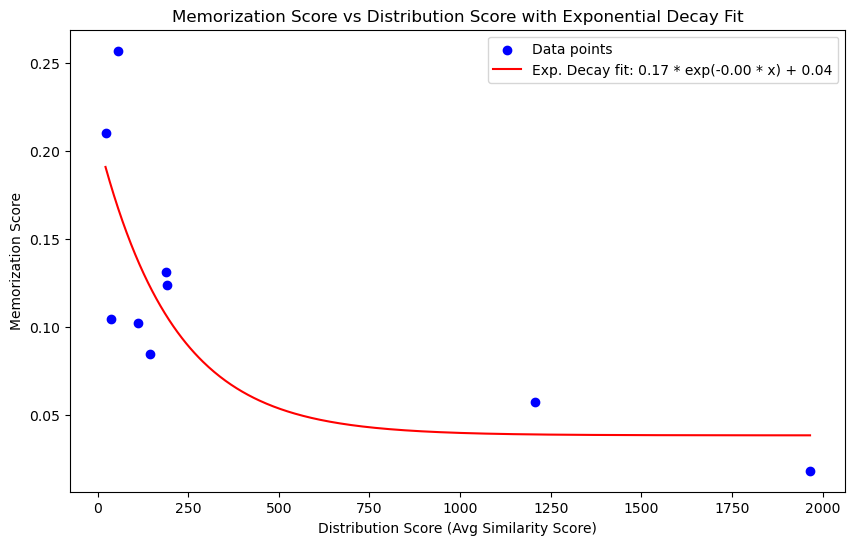

The exponential decay equation is: y = 0.17 * exp(-0.00 * x) + 0.04


In [108]:
def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Merging df that contains the memorization score and the df that contains the average similarity score by moltype
df_merged_scores = pd.merge(memorization_score_df1, df_avg_similarity_by_moltype, on='moltype', how='inner')

# Fitting data
x = df_merged_scores['avg_similarity_score']
y = df_merged_scores['Memorization Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score (Avg Similarity Score)')
plt.ylabel('Memorization Score')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')
